# Import libraries

In [14]:
#IMPORT NECESSARY LIBRARIES AND ESTABLISH LINK WITH FILES
import keras
keras.__version__
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

import matplotlib.pyplot as plt

import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import os
import re

np.set_printoptions(threshold=np.inf) #Prevents array truncation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Making the data usable

In [28]:
header=['NAME','TEAM','AGE','GP','W','L','MIN','OFFRTG','DEFRTG','NETRTG','AST%','AST/TO','AST Ratio','OREB%','DREB%','REB%','TO Ratio','eFG%','TS%','USG%','PACE','PI']
col = {}
for i in np.arange(len(header)):
  col[header[i]]=i

target_header=['TEAM','SEASON','AGAINST TEAM','WIN/LOSS']
target_column = {}
for i in np.arange(len(target_header)):
  target_column[target_header[i]]=i
  
    
os.chdir("/content/drive/My Drive/sports")

In [16]:
winfile = ['sports 96-97.txt', 'sports 97-98.txt', 'sports 98-99.txt', 'sports 99-00.txt', 'sports 00-01.txt', 
           'sports 01-02.txt', 'sports 02-03.txt', 'sports 03-04.txt', 'sports 04-05.txt', 'sports 05-06.txt',
           'sports 06-07.txt', 'sports 07-08.txt', 'sports 08-09.txt', 'sports 09-10.txt', 'sports 10-11.txt',
           'sports 11-12.txt', 'sports 12-13.txt', 'sports 13-14.txt', 'sports 14-15.txt', 'sports 15-16.txt',
           'sports 16-17.txt', 'sports 17-18.txt', 'sports 18-19.txt', 'sports 19-20.txt']

final_tensor = np.zeros((24,541,22))

fspecial = re.sub('\n','\t',open('Target Data Points by team.txt').read()).split('\t')[4:]

for q in range(len(winfile)):
  
  infile = winfile[q]
  text = open(infile).read()
  oneline = re.sub('\n', '\t', text)
  f = oneline.split('\t')


  pnum = {}
  tnum = {}
  team = {}
  name = []

  cols = len(header)
  rows = int(len(f)/(len(header)))

  stats = np.zeros((rows+5,cols))

  teami=1
  for i in np.arange(rows):
    n = i*(cols)
    newname = f[n]
    if f[n+1] not in tnum:
      tnum[f[n+1]] = teami
      teami += 1
    f[n+1] = tnum[f[n+1]]
    if newname not in pnum:
      name.append(newname)
      pnum[name[i]] = i
      f[n] = pnum[f[n]]
      team[name[i]] = f[n+1]
      for j in np.arange(cols):
        stats[i,j] = f[n+j]
  for i in range(len(fspecial)//4):
    n = i*4
    if int(fspecial[n+1]) == q+1:
      fspecial[n] = tnum[fspecial[n]]
      fspecial[n+2] = tnum[fspecial[n+2]]
  for i in range(cols):
    for j in range(rows):
      final_tensor[q,j,i]=stats[j,i]

target_tensor=np.zeros(len(fspecial))
for i in range(len(fspecial)):
  target_tensor[i] = fspecial[i]
target_tensor = target_tensor.reshape((len(fspecial)//4,4))

In [46]:
print(final_tensor[:,:,1])
#ngame = 0
#nsea = target_column[ngame,1]
#team = target_column[game,0]
#home = final_tensor[nsea,final_tensor[nsea,:,1]==team,2:22]

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.
   4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
   5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
   6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
   7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.
   9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10.
  10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11.
  11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
  14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 15.
  15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 16. 16. 16. 16.
  16. 16. 16. 16. 16. 16. 16. 16. 16. 

KeyError: ignored

# Rescaling data

In [47]:
######Rescaling data
#################################################################################
##########First 11 seasons are training data, next 5 are validation, next 8 are test data
#WE MUST MEAN-SUBTRACT AND STD-DIVIDE BY THE MEAN AND STD OF THE ENTIRE TRAINING SET
for n in range(2,22):
  final_tensor_slice = final_tensor[:,:,n]
  final_tensor_slice = final_tensor_slice.reshape(541*24)
  new_list = []
  for i in range(541*11):
    if final_tensor_slice[i] != int(0):
      new_list.append(final_tensor_slice[i])
  avg = np.mean(new_list)
  std = np.std(new_list)

  for i in range(len(final_tensor_slice)):
    if abs(final_tensor_slice[i]) != int(0):
      final_tensor_slice[i] = (final_tensor_slice[i]-avg)/std

In [54]:
infile = 'Target Data Points by team.txt'
text = open(infile).read()
#oneline = re.sub('\t', '', text)
f = text.split('\n')
f = f[1:]

hteam = []
ateam = []
nsea = []
labels = []
for i in np.arange(len(f)):
  z = f[i].split('\t')
  hteam.append(z[0])
  ateam.append(z[2])
  nsea.append(int(z[1]))
  labels.append(z[3])


In [75]:
maxplayers = 25
home = []
away =[]
inmat = np.zeros((len(labels),maxplayers,20,2))
for ig in np.arange(len(labels)):
  if hteam[ig] in tnum and ateam[ig] in tnum:
    hnum = tnum[hteam[ig]]
    anum = tnum[ateam[ig]]
    home = final_tensor[nsea[ig]-1,final_tensor[nsea[ig]-1,:,1]==hnum,2:22]
    away = final_tensor[nsea[ig]-1,final_tensor[nsea[ig]-1,:,1]==anum,2:22]
    nhplay = np.shape(home)[0]
    naplay = np.shape(away)[0]
    inmat[ig,0:nhplay,:,0] = home
    inmat[ig,0:naplay,:,1] = away

In [78]:
labels = keras.utils.to_categorical(labels)
print(np.shape(labels))

(31701, 2)


In [80]:
#Make the training and testing sets
train_data = inmat[:15000,:,:,:]
train_targets = labels[:15000,:]
val_data = inmat[15000:25000,:,:,:]
val_targets = labels[15000:25000,:]
test_data = inmat[25000:,:,:]
test_targets = labels[25000:,:]
#NEED TO FIGURE OUT WHAT FROM THE TARGET TENSOR IS NECESSARY
#premature


In [81]:
print(np.shape(train_data))

(15000, 25, 20, 2)


In [20]:
print(final_tensor[:,:,1])

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.
   4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
   5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
   6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
   7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.
   9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10.
  10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11.
  11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
  14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 15.
  15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 16. 16. 16. 16.
  16. 16. 16. 16. 16. 16. 16. 16. 16. 

# In case you want to test that it worked

In [ ]:
##96-97
query = 0
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -8.21530879e-01 -8.93987895e-01
  -4.26764348e-01 -1.12388988e+00 -3.71186470e-01  6.47142141e-01
   1.44795322e+00 -4.61116850e-01 -6.20420499e-01 -6.75437142e-01
  -7.13124174e-01  1.09633433e+00  6.80825963e-01  9.33556675e-01
  -1.98748646e-01  1.63054641e-01  1.06037193e-01  2.85362353e-01
  -8.47512045e-02 -5.64318760e-02]
 [ 1.00000000e+00  1.00000000e+00 -5.94847322e-01 -2.03662224e+00
   0.00000000e+00 -1.73014197e+00 -6.44333823e-01 -4.06709589e+00
   1.83998717e+00 -4.25064653e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.06912668e+00  6.37035100e+00  3.28104714e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.16395346e-01
  -7.54302204e-01 -1.34536577e+00]
 [ 2.00000000e+00  1.00000000e+00 -1.41480208e-01  1.15487369e+00
   1.84242676e+00 -4.61083740e-02  1.66329037e+00  1.02844081e+00
  -4.86080915e-01  1.09267664e+00 -4.45453472e-02 -4.15932636e-01
  -3.52917097e-01  4.97766011e-01  7.57972065e-01  7.82105677e-01
  -6.7

In [ ]:
##97-98
query = 1
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -5.94847322e-01  6.42658295e-01
   9.59963550e-01  2.12529700e-02  8.06172811e-01  7.16469171e-01
   1.93444593e-01  4.10733942e-01 -7.25125072e-01 -8.22113601e-01
  -1.00783905e+00  1.25958023e+00 -1.29208110e-01  5.29687348e-01
  -5.36933043e-01  3.13094116e-01  4.15046158e-01  9.66557589e-01
  -5.12919011e-01  2.82186351e-01]
 [ 1.00000000e+00  1.00000000e+00 -3.68163765e-01 -6.18179604e-01
  -1.11598916e-01 -9.89167190e-01 -1.35074939e+00  6.70251151e-01
   8.33766707e-01 -4.67719190e-02 -1.22770702e+00 -1.32983981e+00
  -1.35713076e+00  1.91256385e+00  1.10512952e+00  1.61508616e+00
   5.90348282e-01  1.20082768e+00  8.91434979e-01 -7.16395346e-01
   1.00722038e+00 -3.45855388e-02]
 [ 2.00000000e+00  1.00000000e+00  5.38570464e-01 -1.87901750e+00
  -1.37226064e+00  0.00000000e+00 -7.85616937e-01  7.51132686e-01
  -6.79113713e-02  6.17906408e-01 -9.45004676e-01  6.89782216e-01
  -8.22277833e-01 -2.91255859e-01 -5.14938621e-01 -4.79985970e-01
  -1.6

In [ ]:
##98-99
query = 2
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -3.68163765e-01 -5.78778420e-01
  -3.00698175e-01 -7.19721814e-01  8.90942679e-01 -2.77218256e-01
  -1.85521555e-01 -8.13006633e-02 -9.34534219e-01 -1.03648689e+00
  -1.21523101e+00  8.78673121e-01  1.60089773e-01  5.29687348e-01
  -4.99356999e-01 -2.49553916e-01 -2.15847145e-01  7.46170895e-01
  -8.95109066e-01  2.38493676e-01]
 [ 1.00000000e+00  1.00000000e+00 -8.21530879e-01 -1.45365392e-01
   2.66599601e-01 -5.84999126e-01 -2.29903356e-01 -7.50952960e-01
  -7.60504678e-01 -4.67719190e-02  1.17002770e+00  2.94884054e-01
   9.56926817e-01 -1.02586243e+00 -1.13210744e+00 -1.16151546e+00
   4.02468061e-01 -5.74639445e-01 -4.47603869e-01 -2.15516497e-01
  -8.92235457e-01  2.00303043e-02]
 [ 2.00000000e+00  1.00000000e+00 -8.21530879e-01 -4.21173682e-01
   1.44672562e-02 -7.87083158e-01 -1.82808985e-01 -2.42554741e-01
  -6.82097888e-01  2.72618965e-01 -8.19359188e-01 -1.00263848e+00
  -9.96923688e-01 -2.09632907e-01 -1.09353439e+00 -7.82887966e-01
   1.2

In [ ]:
##99-00
query = 3
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -1.41480208e-01  1.15487369e+00
   7.75003424e-02  1.84000926e+00  1.25827877e+00  9.25259029e-02
   7.16156523e-01 -4.00691548e-01 -9.65945591e-01 -9.46224452e-01
  -1.08424662e+00  1.04191903e+00 -3.02786840e-01  3.02510851e-01
  -3.86628867e-01  5.11876154e-04  1.59095784e-02  1.85186583e-01
  -9.19352281e-02 -1.27392016e-02]
 [ 1.00000000e+00  1.00000000e+00  9.91937578e-01  1.07607132e+00
   7.75003424e-02  1.70528657e+00  3.35229099e-01  1.16443681e-02
   4.80936155e-01 -3.14369687e-01  1.06532313e+00  1.61497219e+00
   1.29530316e+00 -1.10748538e+00 -1.01638829e+00 -1.13627363e+00
  -5.55721065e-01 -1.19914134e-02 -9.99687835e-02 -2.15516497e-01
  -7.61303762e-02  4.18766415e-02]
 [ 2.00000000e+00  1.00000000e+00 -1.04821444e+00 -2.63568945e-01
  -8.67995951e-01  4.25421034e-01 -1.07760204e+00 -5.89189890e-01
   4.41732760e-01 -7.28714618e-01 -8.50770560e-01 -8.10830797e-01
  -8.11362467e-01 -2.09632907e-01  5.26533759e-01  2.01543519e-01
  -1.0

In [ ]:
##00-01
query = 4
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00  8.52033493e-02  8.00263032e-01
  -4.26764348e-01  1.77264791e+00  4.01161218e-01 -5.08308356e-01
   1.93444593e-01 -5.04277780e-01 -9.13593304e-01 -1.11546652e+00
  -1.16065418e+00  1.12354198e+00  1.21516722e-01  6.05412847e-01
   4.54956413e-02 -2.24547337e-01 -1.90096398e-01  7.46170895e-01
   2.87563683e-02  9.10713564e-03]
 [ 1.00000000e+00  1.00000000e+00 -1.04821444e+00 -2.03662224e+00
  -1.62439299e+00  0.00000000e+00 -1.87820635e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.08907770e+00  0.00000000e+00]
 [ 2.00000000e+00  1.00000000e+00 -5.94847322e-01  1.22393454e-02
  -8.04962865e-01  8.29589098e-01  6.64889697e-01 -4.73644841e-01
   2.58783585e-01 -5.21542152e-01  1.92390063e+00  2.29194047e+00
   2.49599342e+00 -1.10748538e+00 -4.76365570e-01 -8.08129798e-01
  -2.7

In [ ]:
##01-02
query = 5
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00  3.11886907e-01 -1.05159263e+00
  -8.04962865e-01 -9.89167190e-01 -3.99443092e-01 -9.23461766e-02
  -7.47436880e-01  4.27998314e-01 -9.86886505e-01 -9.80072866e-01
  -1.01875442e+00  5.52181313e-01  5.07247233e-01  6.30654680e-01
  -4.84444691e-02  6.38179646e-01  3.24918543e-01 -3.15692267e-01
  -3.01526252e-02  1.07415653e-01]
 [ 1.00000000e+00  1.00000000e+00 -5.94847322e-01 -2.71618389e-02
  -6.15863606e-01  5.60143722e-01 -8.79805679e-01  2.08070953e-01
  -1.07114766e-01  2.20825849e-01 -1.12300245e+00 -4.38498245e-01
  -1.18248491e+00  3.07312456e-01  2.50840944e-02  1.76301687e-01
  -1.45754613e+00 -1.36234669e+00 -1.10424792e+00 -5.36078961e-01
   6.32396816e-02 -3.29511091e-01]
 [ 2.00000000e+00  1.00000000e+00 -1.41480208e-01 -1.80021513e+00
  -1.62439299e+00 -1.39333525e+00 -1.73390111e-01 -1.09758811e+00
   1.93444593e-01 -9.35887083e-01 -6.93713700e-01 -1.00263848e+00
  -8.98685395e-01  1.44066552e-01 -1.34889567e-02  5.00925218e-02
   4.5

In [ ]:
#02-03
query = 6
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00  5.38570464e-01  1.15487369e+00
   5.18731946e-01  1.36847985e+00 -2.20484482e-01 -3.23436276e-01
   3.37190374e-01 -4.61116850e-01 -9.55475133e-01 -8.10830797e-01
  -8.22277833e-01  1.34120318e+00  6.22966386e-01  1.08500767e+00
  -6.72324912e-02  7.55316137e-02  8.02864461e-02 -1.03695781e+00
  -3.44630393e-02 -2.36623702e-02]
 [ 1.00000000e+00  1.00000000e+00  3.11886907e-01 -1.64261040e+00
  -1.43529373e+00 -1.32597391e+00 -1.34133052e+00 -1.13225162e+00
   5.07071751e-01 -1.17758829e+00 -1.91131750e-01  1.25392245e+00
   3.67497056e-01  9.33088422e-01  1.54871961e+00  1.43839333e+00
  -9.50269529e-01 -2.83773486e+00 -2.68791887e+00 -1.11709843e+00
   4.31244155e-02 -4.27819609e-01]
 [ 2.00000000e+00  1.00000000e+00  9.91937578e-01 -1.91841869e+00
  -1.49832681e+00 -1.73014197e+00 -1.16237191e+00 -1.21313316e+00
  -8.65047064e-01 -3.23001873e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -6.72162969e-01  3.52955029e-01  2.48506888e-02
   4.6

In [ ]:
#03-04
query = 7
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00  7.65254021e-01 -1.83961632e+00
  -1.56135990e+00 -1.52805794e+00 -8.70386805e-01 -1.25935118e+00
   1.14739386e+00 -1.69551946e+00 -8.50770560e-01 -8.10830797e-01
  -9.75092956e-01  3.46339994e+00  3.14381978e-01  1.79177900e+00
  -4.61780955e-01  1.75557931e-01  8.02864461e-02  4.49405053e-02
  -5.73264809e-01  5.44342398e-01]
 [ 1.00000000e+00  1.00000000e+00  7.65254021e-01  1.07607132e+00
   9.59963550e-01  7.62227754e-01  1.49873743e-02  2.31179963e-01
  -5.48435731e-02  2.12193663e-01  1.07579358e+00  9.38003917e-01
   1.01150365e+00  1.44066552e-01  2.56522401e-01  2.77269018e-01
  -2.73900734e-01 -2.99567074e-01  1.06037193e-01  8.50108133e-02
  -1.91074754e-01  4.02341206e-01]
 [ 2.00000000e+00  1.00000000e+00 -1.27489799e+00  9.18466585e-01
   7.75003424e-02  1.43584119e+00  4.38836715e-01 -4.27426821e-01
   1.04954181e-02 -3.23001873e-01  1.75334256e-01  5.79451578e-02
   1.26255706e+00  1.16858901e-01 -5.20620078e-02  5.00925218e-02
   1.1

In [ ]:
#04-05
query = 8
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -5.94847322e-01  5.24454742e-01
  -1.05709521e+00  1.97473195e+00  1.70096586e+00 -1.61673206e-01
   8.72970102e-01 -6.94185874e-01  1.12511512e-01 -4.15932636e-01
  -2.65594170e-01  3.52359492e-02  2.75808926e-01  1.76301687e-01
   6.42836634e-02  7.55316137e-02  8.02864461e-02  1.06673336e+00
  -3.21823983e-01  1.62031496e-01]
 [ 1.00000000e+00  1.00000000e+00  1.21862114e+00 -1.99722106e+00
   0.00000000e+00 -1.66278063e+00 -1.47319476e+00 -3.46545286e-01
  -2.51158964e+00  1.39480315e+00  1.18049816e+00 -4.38498245e-01
   4.54819983e-01  0.00000000e+00 -2.64213789e-01 -9.09097130e-01
   1.36065719e+00  2.56368624e+00  2.12747084e+00 -9.96887502e-01
   5.60643229e+00  6.53574084e-01]
 [ 2.00000000e+00  1.00000000e+00 -1.04821444e+00  5.24454742e-01
  -1.05709521e+00  1.97473195e+00 -2.29903356e-01 -3.23436276e-01
   2.32647988e-01 -3.92059362e-01  6.77916207e-01  3.62580882e-01
   1.14248804e+00 -3.18463510e-01 -3.79932942e-01 -4.04260471e-01
   4.9

In [ ]:
#05-06
query = 9
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -3.68163765e-01  9.18466585e-01
  -1.74632003e-01  1.70528657e+00  1.51258838e+00  6.24033132e-01
   1.27807185e+00 -3.74794989e-01  1.85804714e-01 -1.90276544e-01
  -2.98340267e-01 -1.55217606e-01  6.22966386e-01  3.27752684e-01
  -3.67840845e-01  2.13067799e-01  1.44663314e-01  1.48747159e+00
  -5.14355816e-01  2.71263182e-01]
 [ 1.00000000e+00  1.00000000e+00 -1.41480208e-01 -1.60320921e+00
  -1.37226064e+00 -1.32597391e+00 -1.08702091e+00  1.01688630e+00
  -6.42894494e-01  1.19626287e+00 -7.59567192e-02 -4.38498245e-01
  -1.45525144e-01 -1.27073128e+00  2.37235875e-01 -3.28534972e-01
   3.27315973e-01  1.30085399e+00  1.12319170e+00  5.25784201e-01
   6.16409499e-01  3.58648531e-01]
 [ 2.00000000e+00  1.00000000e+00 -1.27489799e+00 -1.16979618e+00
  -1.30922756e+00 -6.52360470e-01 -1.41668151e+00  6.93360161e-01
  -3.16199538e-01  7.30124827e-01 -3.69129524e-01  9.71852331e-01
   4.54819983e-01 -8.08201223e-01 -4.95652095e-01 -6.81920634e-01
  -7.2

In [ ]:
#06-07
query = 10
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00  9.91937578e-01  5.63855926e-01
   8.33897377e-01  2.12529700e-02 -1.07457991e-01  1.96516448e-01
   5.72410742e-01 -2.28047826e-01  1.17002770e+00  1.41188171e+00
   1.65551024e+00 -1.02586243e+00 -1.15139396e+00 -1.18675729e+00
  -1.98748646e-01 -1.49527599e-01 -2.80224013e-01 -5.36078961e-01
  -1.40786589e-01 -1.65663562e-01]
 [ 1.00000000e+00  1.00000000e+00 -8.21530879e-01 -1.16979618e+00
  -1.12012830e+00 -8.54444502e-01 -1.11527754e+00 -7.85616475e-01
  -5.64487704e-01 -2.10783454e-01 -6.51831871e-01 -4.38498245e-01
  -9.09483143e-02 -1.13469303e+00 -5.53511672e-01 -8.83855297e-01
   4.21256083e-01 -1.92499472e+00 -2.44328677e+00 -1.51780151e+00
   3.07496484e-01 -1.11597923e+00]
 [ 2.00000000e+00  1.00000000e+00 -8.21530879e-01 -1.83961632e+00
  -1.62439299e+00 -1.46069660e+00 -1.14353416e+00 -2.65663751e-01
   3.50258172e-01 -4.26588106e-01 -6.93713700e-01  6.89782216e-01
  -6.36716612e-01  4.16143059e-01  5.79756882e-03  2.26785352e-01
  -1.4

In [ ]:
#07-08
query = 11
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -1.04821444e+00  1.30442898e-01
  -1.11598916e-01  2.90698346e-01 -4.74794086e-01 -2.30191468e-02
   6.90020926e-01 -4.69749036e-01  8.45443524e-01  7.12347825e-01
   1.16431877e+00 -1.13469303e+00 -1.36354574e+00 -1.38869196e+00
   6.42836634e-02 -5.74639445e-01 -6.02108352e-01 -4.75973499e-01
  -9.04984234e-02 -2.85818417e-01]
 [ 1.00000000e+00  1.00000000e+00 -1.27489799e+00  1.11547251e+00
   6.44798119e-01  1.16639582e+00  1.02280692e+00  6.24033132e-01
   7.29224321e-01 -3.61098872e-03 -6.20420499e-01 -5.40043486e-01
  -4.07493927e-01  1.25958023e+00  1.89587707e+00  1.84226266e+00
   1.20647730e-01  4.63133591e-01  4.79423026e-01 -4.55938345e-01
  -3.49123273e-01  2.60340014e-01]
 [ 2.00000000e+00  1.00000000e+00 -8.21530879e-01 -1.01219145e+00
  -9.31029038e-01 -7.87083158e-01 -1.47319476e+00 -9.82043059e-01
   1.34341084e+00 -1.61782978e+00 -1.14394336e+00 -1.19444615e+00
  -1.31346930e+00 -1.32514659e+00 -1.09353439e+00 -1.36345012e+00
  -2.7

In [ ]:
#08-09
query = 12
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -8.21530879e-01  9.10417141e-02
   3.92665774e-01 -3.15553750e-01 -9.73994421e-01 -6.92371667e-02
  -2.63928345e-01  1.34503988e-01  1.25379136e+00  1.78421426e+00
   1.64459487e+00 -1.21631598e+00 -7.27090402e-01 -9.59580796e-01
  -4.42992933e-01 -6.99672341e-01 -1.51470278e-01 -5.16043807e-01
  -1.86764340e-01  9.64924845e-02]
 [ 1.00000000e+00  1.00000000e+00 -1.04821444e+00  5.63855926e-01
   8.96930464e-01 -4.61083740e-02  1.22060328e+00  9.12895756e-01
   6.76953128e-01  2.38090221e-01 -1.91131750e-01  2.15904422e-01
   1.49189737e-01  3.61727758e-01  1.89587707e+00  1.46363517e+00
  -3.49052822e-01  7.88219121e-01  8.14182738e-01 -3.55762575e-01
  -6.73841140e-01  4.89726555e-01]
 [ 2.00000000e+00  1.00000000e+00  3.11886907e-01  1.07607132e+00
   1.21209589e+00  4.92782378e-01  3.91742344e-01  1.00533180e+00
   2.97986979e-01  5.57481105e-01  3.92183113e-02 -1.78993739e-01
  -2.76509536e-01 -1.18910833e+00 -9.58528709e-01 -1.13627363e+00
  -3.6

In [ ]:
#09-10
query = 13
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -8.21530879e-01  1.11547251e+00
   1.59029441e+00  1.55975658e-01  1.37130527e+00  1.60616605e+00
   4.15597163e-01  9.28665106e-01 -3.69129524e-01  1.82056008e-01
  -1.12779046e-01  8.78673121e-01  1.58729266e+00  1.48887700e+00
  -5.93297109e-01  1.12580794e+00  1.18756857e+00 -1.15340727e-01
  -6.33610607e-01  5.66188735e-01]
 [ 1.00000000e+00  1.00000000e+00  5.38570464e-01  1.03667014e+00
   1.52726133e+00  8.86143140e-02  9.94550296e-01  1.39818496e+00
   7.03088725e-01  5.83377664e-01  2.69568372e-01  3.96429296e-01
  -1.12779046e-01 -1.13469303e+00 -1.05496134e+00 -1.18675729e+00
  -7.99965352e-01  7.63212542e-01  9.17185726e-01  1.32719036e+00
  -3.06019131e-01  4.35110712e-01]
 [ 2.00000000e+00  1.00000000e+00  7.65254021e-01 -1.13039500e+00
  -6.15863606e-01 -1.32597391e+00 -1.48261363e+00 -8.43389000e-01
  -6.69030090e-01 -1.84886896e-01 -8.82181932e-01 -6.64154337e-01
  -4.07493927e-01 -4.00086462e-01 -9.58528709e-01 -7.82887966e-01
   4.5

In [ ]:
#10-11
query = 14
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -5.94847322e-01  9.57867770e-01
   8.96930464e-01  6.27505066e-01  1.37130527e+00  7.74241696e-01
   5.07071751e-01  2.46722407e-01  3.32391116e-01  9.60569526e-01
   3.67497056e-01  4.70558360e-01  1.64515224e+00  1.33742600e+00
  -7.81177330e-01  1.20082768e+00  1.09744096e+00  2.85362353e-01
  -6.63783507e-01  7.62805770e-01]
 [ 1.00000000e+00  1.00000000e+00  7.65254021e-01 -2.71618389e-02
  -1.11598916e-01  2.12529700e-02 -7.10265943e-01 -1.15455187e-01
   6.50817532e-01 -5.12909966e-01 -4.00540896e-01  6.33368193e-01
   2.47428030e-01 -5.08917065e-01 -3.99219468e-01 -4.54744137e-01
  -6.49661176e-01  6.13173067e-01  7.11179750e-01 -1.17720389e+00
  -6.17623290e-02 -1.11047719e-01]
 [ 2.00000000e+00  1.00000000e+00  1.21862114e+00 -1.56380803e+00
  -1.30922756e+00 -1.32597391e+00 -1.34133052e+00 -1.84782216e-01
   1.29113965e+00 -9.96312386e-01 -9.13593304e-01 -1.11546652e+00
  -1.10607735e+00  3.88935408e-01  1.79944444e+00  1.28694234e+00
   2.8

In [ ]:
#11-12
query = 15
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -3.68163765e-01 -1.64261040e+00
  -1.24619447e+00 -1.52805794e+00  1.04164467e+00  1.08621333e+00
  -1.33250363e-01  9.02768548e-01 -2.53954493e-01  1.25641985e-01
  -2.54561186e-02  5.79388963e-01  6.03679861e-01  6.81138346e-01
  -4.42992933e-01  1.13831123e+00  1.07169021e+00 -1.75446189e-01
  -6.49415459e-01  5.44342398e-01]
 [ 1.00000000e+00  1.00000000e+00  1.89867181e+00 -1.48500566e+00
  -1.24619447e+00 -1.25861257e+00 -1.40726264e+00  4.39161052e-01
  -1.56401784e-02  3.41676454e-01 -7.98418274e-01 -6.61656929e-02
   1.18614950e+00  1.96697915e+00  1.60657919e+00  1.96847183e+00
   1.36065719e+00 -4.21309672e+00 -4.85098162e+00 -2.51955921e+00
  -5.17046960e-02 -4.82435452e-01]
 [ 2.00000000e+00  1.00000000e+00  8.52033493e-02  1.30442898e-01
   5.18731946e-01 -3.82915094e-01 -3.61767595e-01  4.63078830e-02
  -6.16758897e-01  4.36630500e-01 -8.19359188e-01 -1.04776969e+00
  -8.87770029e-01  4.70558360e-01  1.00869690e+00  9.33556675e-01
   7.2

In [ ]:
#12-13
query = 16
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -1.41480208e-01  8.39664217e-01
   9.59963550e-01  3.58059690e-01  1.56910162e+00  7.62687191e-01
   1.67308997e-01  4.62527059e-01  1.22981970e-01  2.72318445e-01
  -2.54561186e-02  5.79388963e-01  1.56800614e+00  1.38790967e+00
  -5.93297109e-01  1.03828491e+00  7.49805870e-01  7.26135741e-01
  -2.74409428e-01  6.86343590e-01]
 [ 1.00000000e+00  1.00000000e+00  8.52033493e-02  3.66850005e-01
   7.75003424e-02  4.92782378e-01 -4.74794086e-01 -2.88772761e-01
  -2.37792748e-01 -6.40362912e-02 -8.92652389e-01 -5.62609095e-01
  -5.93055148e-01 -6.44955318e-01  6.36571455e-02 -2.27567641e-01
  -1.98748646e-01  2.75584247e-01  3.76420038e-01 -1.07702812e+00
   2.06920154e-01 -1.76586731e-01]
 [ 2.00000000e+00  1.00000000e+00  9.91937578e-01  9.97268954e-01
   5.18731946e-01  1.09903447e+00 -7.10265943e-01 -5.76826617e-02
   1.67308997e-01 -1.50358152e-01 -7.04184158e-01 -1.45145325e-01
  -2.65594170e-01 -8.62616524e-01 -1.01638829e+00 -1.01006446e+00
  -4.0

In [ ]:
#13-14
query = 17
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00  8.52033493e-02 -9.33389079e-01
  -6.78896693e-01 -9.21805846e-01  1.17350891e+00  5.89369617e-01
  -2.87079766e-02  4.53894873e-01  1.82773966e-02 -2.24124957e-01
  -3.42001731e-01  4.43350710e-01  1.24013520e+00  1.05976584e+00
  -3.86628867e-01  1.36337044e+00  1.11031633e+00  1.22701459e+00
   3.29048555e-01  7.95575276e-01]
 [ 1.00000000e+00  1.00000000e+00  3.11886907e-01  2.48646451e-01
   1.44672562e-02  3.58059690e-01 -5.50145080e-01 -3.46545286e-01
   2.45715786e-01 -4.17955920e-01 -7.67006902e-01 -4.72346659e-01
  -7.24039540e-01 -1.10748538e+00 -1.87067687e-01 -6.31436968e-01
  -6.12085132e-01  8.75742148e-01  7.75556617e-01 -3.35727421e-01
   4.35372104e-01 -5.64318760e-02]
 [ 2.00000000e+00  1.00000000e+00 -1.41480208e-01  8.00263032e-01
   6.44798119e-01  6.27505066e-01  1.08873904e+00  7.16469171e-01
   2.45715786e-01  3.76205198e-01 -5.15715926e-01  3.51298077e-01
  -1.23694412e-01 -2.09632907e-01  4.43706199e-02 -2.56329771e-02
  -7.8

In [ ]:
#14-15
query = 18
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00  3.11886907e-01  9.18466585e-01
   1.84242676e+00 -4.50276438e-01  9.38037050e-01  9.59113776e-01
  -6.79113713e-02  7.64653571e-01  4.26625232e-01  1.18622562e+00
   2.14681932e-01  1.44066552e-01  9.31550795e-01  7.82105677e-01
  -1.02542162e+00  1.02578162e+00  7.88431991e-01  7.46170895e-01
   2.05483349e-01  7.08189927e-01]
 [ 1.00000000e+00  1.00000000e+00 -1.41480208e-01 -7.36383157e-01
  -6.15863606e-01 -6.52360470e-01 -9.83413296e-01 -9.23461766e-02
   1.93444593e-01 -1.93519082e-01 -5.68068213e-01 -7.31851165e-01
  -7.24039540e-01 -7.53785921e-01  1.06655647e+00  4.03478183e-01
  -4.84444691e-02 -2.74560495e-01 -6.79360593e-01  5.65854509e-01
   5.83362990e-01 -1.54740394e-01]
 [ 2.00000000e+00  1.00000000e+00  8.52033493e-02  6.82059479e-01
   1.65332750e+00 -6.52360470e-01  1.01338804e+00  1.08621333e+00
   2.06512392e-01  6.69699524e-01 -5.68068213e-01  2.04621618e-01
  -3.31086365e-01 -2.09632907e-01  5.79756882e-03 -2.56329771e-02
  -8.7

In [ ]:
#15-16
query = 19
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00  5.38570464e-01  1.15487369e+00
   1.33816207e+00  4.92782378e-01  1.08873904e+00  4.27606547e-01
  -3.42335134e-01  5.48848919e-01  2.90509287e-01  1.20879123e+00
   2.14681932e-01  8.02829854e-03  6.42252912e-01  5.04445515e-01
  -1.02542162e+00  1.06329149e+00  8.14182738e-01  3.85538123e-01
   7.28480267e-01  6.20804578e-01]
 [ 1.00000000e+00  1.00000000e+00 -1.27489799e+00  1.07607132e+00
   1.27512898e+00  4.25421034e-01 -2.26881226e-02  4.85379072e-01
  -7.08233485e-01  8.33711059e-01  2.41601212e+00  5.88236974e-01
   1.01150365e+00 -1.08027773e+00 -3.60646417e-01 -6.81920634e-01
   6.42836634e-02  1.13041483e-01  1.06037193e-01  2.06849106e+00
   4.79913050e-01  4.46033880e-01]
 [ 2.00000000e+00  1.00000000e+00 -8.21530879e-01 -1.64261040e+00
  -1.24619447e+00 -1.52805794e+00 -1.31307389e+00  1.22486739e+00
   1.67010579e+00 -1.84886896e-01 -8.61241017e-01 -8.89810429e-01
  -6.69462710e-01  1.61327969e+00  1.39442741e+00  1.76653716e+00
   6.2

In [ ]:
#16-17
query = 20
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -1.27489799e+00 -5.78778420e-01
  -4.26764348e-01 -5.84999126e-01 -1.01166992e+00  3.47533780e-02
   2.58783585e-01 -1.41725966e-01 -1.49249920e-01  4.07712101e-01
   3.34750958e-01 -5.08917065e-01 -9.06350589e-02 -2.78051307e-01
  -3.67840845e-01  2.88087537e-01 -2.67348640e-01 -7.76500808e-01
   3.98015181e-01 -8.92013819e-02]
 [ 1.00000000e+00  1.00000000e+00 -1.04821444e+00  1.03667014e+00
   9.59963550e-01  6.94866410e-01  1.03222579e+00  7.04914666e-01
   7.16156523e-01  5.68143137e-02  2.12283932e+00  6.10802583e-01
   8.91434621e-01 -1.05307008e+00 -8.81382606e-01 -1.03530630e+00
  -6.72324912e-02  3.88113854e-01  4.02170785e-01  1.78799890e+00
   5.96294233e-01  4.02341206e-01]
 [ 2.00000000e+00  1.00000000e+00  7.65254021e-01  8.39664217e-01
   6.44798119e-01  6.94866410e-01  8.62686056e-01  4.39161052e-01
   4.80936155e-01  1.36533834e-02 -6.41361414e-01 -8.78527624e-01
  -6.80378076e-01  2.10301740e+00  2.95663598e+00  2.97814514e+00
   5.7

In [ ]:
#17-18
query = 21
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -5.94847322e-01 -1.48500566e+00
  -1.62439299e+00 -8.54444502e-01 -6.25496074e-01 -8.78052515e-01
   1.17352946e+00 -1.41928950e+00 -9.13593304e-01 -7.20568360e-01
  -9.86008322e-01 -1.08027773e+00  1.60089773e-01 -4.29502304e-01
  -6.87237220e-01  5.05250346e-02 -5.24856110e-01 -4.55938345e-01
   1.28452369e+00 -3.40434260e-01]
 [ 1.00000000e+00  1.00000000e+00 -8.21530879e-01 -1.40620329e+00
  -1.24619447e+00 -1.12388988e+00 -1.25656065e+00 -1.38645073e+00
  -2.87079766e-02 -1.01357676e+00 -1.17535474e+00 -1.23957737e+00
  -1.06241588e+00 -9.17031825e-01 -7.65663453e-01 -9.34338963e-01
   1.58611345e+00 -1.24521020e-01 -2.02971772e-01 -1.51780151e+00
   1.18394736e+00 -8.21053679e-01]
 [ 2.00000000e+00  1.00000000e+00 -5.94847322e-01 -1.48500566e+00
  -1.43529373e+00 -1.05652853e+00  6.08376452e-01  1.73407438e-01
   3.89461567e-01 -1.24461594e-01 -2.95836323e-01  7.68761848e-01
  -1.89186608e-01 -8.62616524e-01  2.56522401e-01 -2.27567641e-01
  -1.1

In [ ]:
#18-19
query = 22
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -3.68163765e-01  9.57867770e-01
   7.75003424e-02  1.50320254e+00 -4.15258711e-02  7.85796201e-01
   1.18659726e+00 -1.93519082e-01 -5.36656841e-01 -5.62609095e-01
  -7.13124174e-01  9.33088422e-01  6.61539437e-01  8.83073009e-01
  -4.24204911e-01  1.11330465e+00  9.42936473e-01  6.25959971e-01
   1.82763588e+00  2.16647339e-01]
 [ 1.00000000e+00  1.00000000e+00 -5.94847322e-01 -1.24859855e+00
  -1.24619447e+00 -8.54444502e-01 -5.68982829e-01  2.65843477e-01
   1.33034304e+00 -6.76921502e-01 -5.47127298e-01 -8.87313021e-02
  -2.32848072e-01  7.97050169e-01  5.07247233e-01  7.06380178e-01
  -4.24204911e-01  1.08829807e+00  8.91434979e-01 -8.56641424e-01
   1.66671375e+00 -1.21970888e-01]
 [ 2.00000000e+00  1.00000000e+00 -1.04821444e+00 -1.32740092e+00
  -1.24619447e+00 -9.89167190e-01 -9.26900050e-01  3.00506992e-01
   7.03088725e-01 -2.36680012e-01  2.06745628e-01 -9.75166985e-03
   6.51296570e-01 -3.45671161e-01  7.00112488e-01  3.27752684e-01
   5.7

In [ ]:
##18-19
query = 23
print(final_tensor[query,:,:])

[[ 0.00000000e+00  1.00000000e+00 -8.21530879e-01 -7.36383157e-01
  -8.67995951e-01 -3.82915094e-01 -7.38522565e-01 -5.42971871e-01
   8.99105698e-01 -1.00494457e+00  7.40738951e-01  4.18994905e-01
   2.36512664e-01 -8.89824175e-01  1.40803248e-01 -3.28534972e-01
  -4.80568977e-01  7.55316137e-02  6.74110725e-02  7.46170895e-01
   1.42964097e+00  1.51108328e-01]
 [ 1.00000000e+00  1.00000000e+00 -1.50158155e+00  1.30442898e-01
  -5.52830520e-01  7.62227754e-01 -7.38522565e-01  3.23616002e-01
   8.20698909e-01 -2.97105315e-01 -3.79599981e-01 -2.46690567e-01
  -3.62538671e-03  7.97050169e-01  1.04726995e+00  1.05976584e+00
   1.39435752e-01  8.50735569e-01  5.18049147e-01 -7.16395346e-01
   1.32044381e+00 -1.27392016e-02]
 [ 2.00000000e+00  1.00000000e+00 -1.72826511e+00  2.09245267e-01
  -6.15863606e-01  9.64311786e-01  5.80119829e-01  8.89786746e-01
   1.55249561e+00 -3.57530617e-01 -6.09950042e-01 -5.40043486e-01
  -5.27562952e-01 -9.44239476e-01 -2.83500314e-01 -6.06195135e-01
  -1.2

In [ ]:
print(final_tensor.shape)

(24, 541, 22)


# This is the part where we get the model together

In [82]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(maxplayers,20,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


num_epochs = 50  # For each partition, run 200 epochs to train.
all_mae_histories = [] # Save each history, so we can see how it does

history = model.fit(train_data,
                    train_targets,
                    epochs=20,
                    validation_data=(val_data, val_targets))

history_dict = history.history
history_dict.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

Epoch 1/20
469/469 [==============================] - 17s 37ms/step - loss: 0.6834 - accuracy: 0.6054 - val_loss: 0.6907 - val_accuracy: 0.5563
Epoch 2/20
469/469 [==============================] - 17s 36ms/step - loss: 0.6400 - accuracy: 0.6417 - val_loss: 0.7288 - val_accuracy: 0.5890
Epoch 3/20
469/469 [==============================] - 17s 36ms/step - loss: 0.6217 - accuracy: 0.6533 - val_loss: 0.7375 - val_accuracy: 0.5252
Epoch 4/20
469/469 [==============================] - 17s 36ms/step - loss: 0.6089 - accuracy: 0.6657 - val_loss: 0.7433 - val_accuracy: 0.5300
Epoch 5/20
469/469 [==============================] - 17s 36ms/step - loss: 0.5978 - accuracy: 0.6742 - val_loss: 0.7518 - val_accuracy: 0.5720
Epoch 6/20
469/469 [==============================] - 17s 36ms/step - loss: 0.5900 - accuracy: 0.6815 - val_loss: 0.7883 - val_accuracy: 0.5618
Epoch 7/20
469/469 [==============================] - 17s 36ms/step - loss: 0.5825 - accuracy: 0.6861 - val_loss: 0.7946 - val_accuracy:

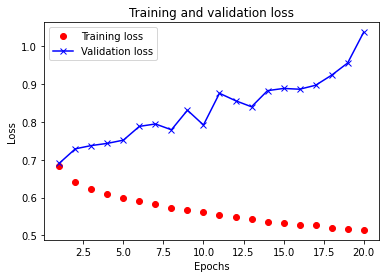

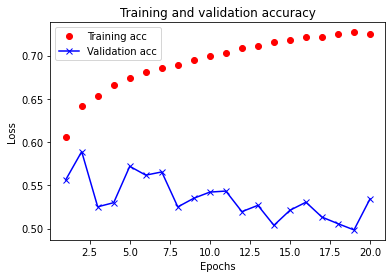

In [83]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'ro', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'bx-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()





plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'bx-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [84]:
# Copy the code here that trains the model, but instead of going all the way out to 20 epochs, stop at the epoch you think makes the most sense.
best_epoch = 5 # Change this!!!
model.fit(train_data, train_targets, epochs=best_epoch)


Epoch 1/5
469/469 [==============================] - 15s 32ms/step - loss: 0.5150 - accuracy: 0.7242
Epoch 2/5
469/469 [==============================] - 15s 32ms/step - loss: 0.5107 - accuracy: 0.7331
Epoch 3/5
469/469 [==============================] - 15s 32ms/step - loss: 0.5104 - accuracy: 0.7327
Epoch 4/5
469/469 [==============================] - 15s 33ms/step - loss: 0.5069 - accuracy: 0.7321
Epoch 5/5
469/469 [==============================] - 15s 33ms/step - loss: 0.5051 - accuracy: 0.7339


In [85]:
results = model.evaluate(test_data, test_targets)
print(results)

210/210 [==============================] - 1s 6ms/step - loss: 1.2976 - accuracy: 0.5025
[1.2975716590881348, 0.5024623274803162]


In [ ]:
predictions = model.predict(x_test)
print(np.shape(predictions))
print('Review\tLabel\tPrediction')
for i in np.arange(30):
  print(i, '\t',test_labels[i],'\t',predictions[i]) 



In [ ]:
#FROM THE BOSTON HOUSING MODEL EXAMPLE

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model






num_epochs = 200  # For each partition, run 200 epochs to train.
all_mae_histories = [] # Save each history, so we can see how it does

k = 4 # Use four partitions
num_val_samples = len(train_data) // k # Divide by k and round down

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)




average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]




plt.plot(average_mae_history)
#plt.plot(average_mae_history[10:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()






# Get a fresh, compiled model.
max_epoch = 48
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=max_epoch, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)





test_mae_score






predictions = model.predict(test_data)







plt.figure(figsize=(18,5))
plt.plot(predictions[:,0],'r.',label='Predictions')
plt.plot(test_targets,'bx',label='Targets')
plt.ylabel('Cost of House (k$)')
plt.legend()
plt.show()

plt.figure(figsize=(18,5))
resid = predictions[:,0]-test_targets
plt.plot(resid,'g+')
plt.ylabel('Diff. btw. Prediction and Actual')
plt.show()

plt.hist(resid,bins=20)
plt.xlabel('Diff. btw. Prediction and Actual')
plt.ylabel('Number of Cases')
plt.show()






new_mae = []  # Set up an empty array to keep the results

for i in np.arange(13): # Loop through the 13 inputs
  permutation = np.copy(test_data) # Make a copy of the test data
  permutation[:,i] = 0.0 # Set a particular column of inputs to zero
  p_mse, p_mae = model.evaluate(permutation, test_targets) # evaluate the modified data
  new_mae.append(p_mae-test_mae_score) # save the change in MAE to the array

plt.bar(np.arange(13)+1,new_mae) # Make a bar graph to show change in result
plt.ylabel('Change in MAE')
plt.xlabel('Parameter Number (see list above)')
plt.show()








num_epochs = 200  # For each partition, run 200 epochs to train.
all_mae_histories = [] # Save each history, so we can see how it does

k = 5 # Use four partitions
num_val_samples = len(train_data) // k # Divide by k and round down

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)






average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]







plt.plot(average_mae_history)
#plt.plot(average_mae_history[10:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

processing fold # 0


ValueError: ignored